 Bibliothèques importées
 Données chargées : 1831 matchs, 33 colonnes

 FEATURE ENGINEERING POUR LA PRÉDICTION DE MATCHS

1. FEATURES DE FORME RÉCENTE
Calcul de la forme récente des équipes...
 Forme récente calculée
   • HomeForm_5 : Moyenne = 0.454
   • AwayForm_5 : Moyenne = 0.468

2. FEATURES DE PERFORMANCE
 Statistiques moyennes calculées
   • Nombre de nouvelles features : 10

3. FEATURES CONTEXTUELLES
 Features contextuelles créées
   • ImportanceMatch : 0.386
   • FormDiff        : -0.014

4. ENCODAGE DES VARIABLES CATÉGORIELLES
 Variables catégorielles encodées
   • Nombre d'équipes uniques : 98
   • Nombre d'arbitres uniques : 24

5. NORMALISATION DES FEATURES
Features normalisées
   • Features normalisées : 13

6. SÉLECTION DE FEATURES
 Top 15 des features les plus importantes :
                    Feature        Score
11          GoalDiff_scaled  2415.357550
6                  GoalDiff  2415.357550
0                 HomeGoals   687.137186
1                 AwayGoals   627.4

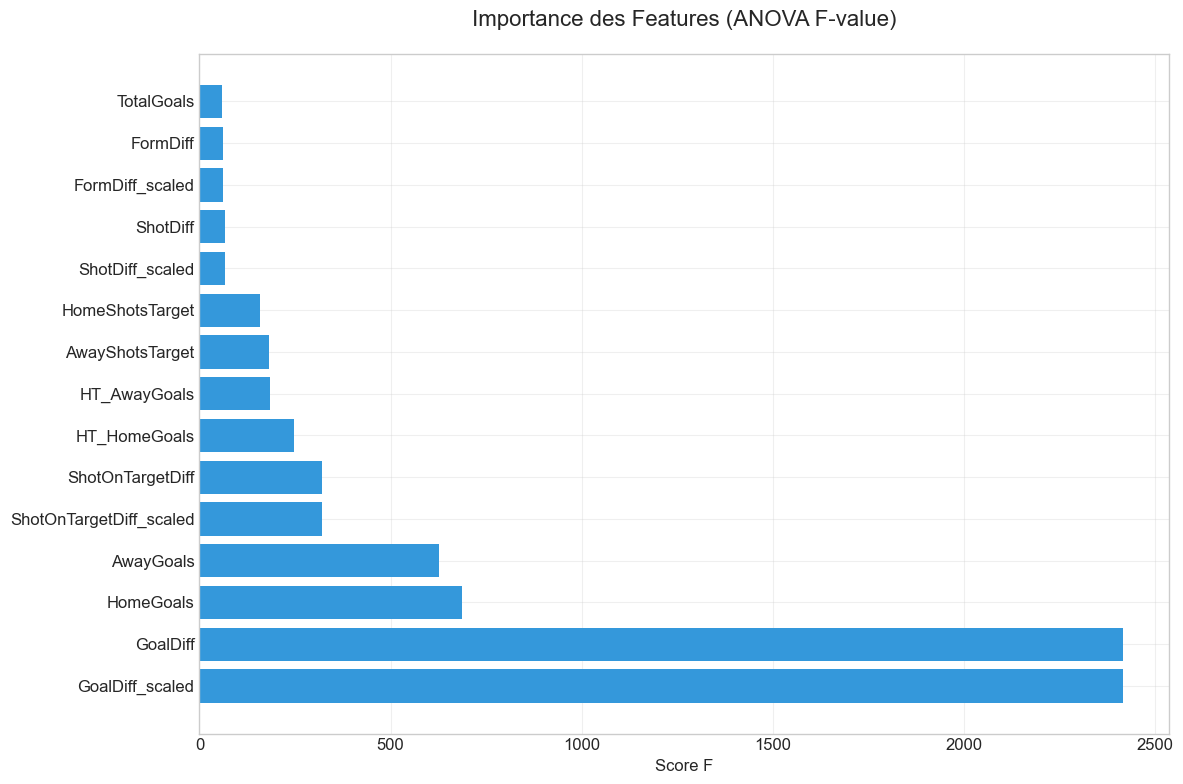

 Liste des features sélectionnées sauvegardée : ../data/processed/selected_features.txt

7. VÉRIFICATION FINALE DES DONNÉES

 Dimensions finales : 1831 lignes, 69 colonnes

 Aperçu des nouvelles features :
   • 38 nouvelles features créées
   • Exemples : GoalDiff, ShotDiff, ShotOnTargetDiff, CornerDiff, YellowCardDiff, RedCardDiff, FoulDiff, HomeForm_5, AwayForm_5, HomeForm_10...

 Vérification des valeurs manquantes :
                Missing  Percentage
Referee            1451   79.246313
HomeTeam              0    0.000000
AwayTeam              0    0.000000
HomeGoals             0    0.000000
Date                  0    0.000000
AwayGoals             0    0.000000
FullTimeResult        0    0.000000
HT_AwayGoals          0    0.000000
HT_HomeGoals          0    0.000000
HalfTimeResult        0    0.000000

8. SAUVEGARDE DES DONNÉES
 Dataset avec features sauvegardé : ../data/processed/matches_with_features.csv
   • Taille : 0.98 MB
   • Features totales : 69

 RÉSUMÉ DU FEATURE ENGI

In [1]:
# 02 - Feature Engineering
# Création de features avancées pour la prédiction des matchs

# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
import os
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(" Bibliothèques importées")

# %%
# Chargement des données traitées
data_path = "../data/processed/matches_processed.csv"
try:
    df = pd.read_csv(data_path)
    print(f" Données chargées : {df.shape[0]} matchs, {df.shape[1]} colonnes")
except FileNotFoundError:
    print(" Fichier non trouvé. Exécuter d'abord le notebook 01.")
    exit()

print("\n" + "="*70)
print(" FEATURE ENGINEERING POUR LA PRÉDICTION DE MATCHS")
print("="*70)

# %%
# 1. Features de forme récente des équipes
print("\n" + "="*50)
print("1. FEATURES DE FORME RÉCENTE")
print("="*50)

def calculer_forme_equipe(df, equipe_col, buts_col, result_col, window=5):
    """Calcule la forme récente d'une équipe sur les N derniers matchs."""
    forme = []
    for i, row in df.iterrows():
        equipe = row[equipe_col]
        
        # Récupérer les matchs précédents de cette équipe
        if equipe_col == 'HomeTeam':
            mask = (df['HomeTeam'] == equipe) | (df['AwayTeam'] == equipe)
        else:
            mask = (df['HomeTeam'] == equipe) | (df['AwayTeam'] == equipe)
        
        # Sélectionner les matchs précédents (avant la date du match actuel)
        previous_matches = df.loc[:i-1][mask].tail(window)
        
        if len(previous_matches) > 0:
            # Calculer la moyenne des points (3 pour victoire, 1 pour nul, 0 pour défaite)
            points = 0
            for _, match in previous_matches.iterrows():
                if match['HomeTeam'] == equipe:
                    if match['ResultCode'] == 1:
                        points += 3
                    elif match['ResultCode'] == 0:
                        points += 1
                else:  # AwayTeam
                    if match['ResultCode'] == -1:
                        points += 3
                    elif match['ResultCode'] == 0:
                        points += 1
            
            forme_score = points / (len(previous_matches) * 3)  # Normalisé entre 0 et 1
        else:
            forme_score = 0.5  # Valeur par défaut si pas assez de données
        
        forme.append(forme_score)
    
    return forme

# Calculer la forme pour les équipes à domicile et à l'extérieur
print("Calcul de la forme récente des équipes...")
df['HomeForm_5'] = calculer_forme_equipe(df, 'HomeTeam', 'HomeGoals', 'ResultCode', window=5)
df['AwayForm_5'] = calculer_forme_equipe(df, 'AwayTeam', 'AwayGoals', 'ResultCode', window=5)

# Forme sur 10 matchs
df['HomeForm_10'] = calculer_forme_equipe(df, 'HomeTeam', 'HomeGoals', 'ResultCode', window=10)
df['AwayForm_10'] = calculer_forme_equipe(df, 'AwayTeam', 'AwayGoals', 'ResultCode', window=10)

print(f" Forme récente calculée")
print(f"   • HomeForm_5 : Moyenne = {df['HomeForm_5'].mean():.3f}")
print(f"   • AwayForm_5 : Moyenne = {df['AwayForm_5'].mean():.3f}")

# %%
# 2. Features de performance offensive/défensive
print("\n" + "="*50)
print("2. FEATURES DE PERFORMANCE")
print("="*50)

def calculer_stats_moyennes(df, equipe_col, stats_cols, window=10):
    """Calcule les statistiques moyennes d'une équipe."""
    stats_dict = {f'{col}_avg': [] for col in stats_cols}
    
    for i, row in df.iterrows():
        equipe = row[equipe_col]
        
        # Récupérer les matchs précédents
        if equipe_col == 'HomeTeam':
            mask = (df['HomeTeam'] == equipe)
            prefix = 'Home'
        else:
            mask = (df['AwayTeam'] == equipe)
            prefix = 'Away'
        
        previous_matches = df.loc[:i-1][mask].tail(window)
        
        for col in stats_cols:
            if len(previous_matches) > 0:
                avg_value = previous_matches[col].mean()
            else:
                avg_value = df[col].mean()  # Valeur globale par défaut
            
            stats_dict[f'{col}_avg'].append(avg_value)
    
    return stats_dict

# Statistiques pour les équipes à domicile
home_stats = calculer_stats_moyennes(df, 'HomeTeam', 
                                     ['HomeGoals', 'HomeShots', 'HomeShotsTarget', 
                                      'HomeCorners', 'HomeFouls'], window=10)

# Statistiques pour les équipes à l'extérieur
away_stats = calculer_stats_moyennes(df, 'AwayTeam',
                                     ['AwayGoals', 'AwayShots', 'AwayShotsTarget',
                                      'AwayCorners', 'AwayFouls'], window=10)

# Ajouter les features au DataFrame
for key, values in home_stats.items():
    df[f'Home_{key}'] = values

for key, values in away_stats.items():
    df[f'Away_{key}'] = values

print(" Statistiques moyennes calculées")
print(f"   • Nombre de nouvelles features : {len(home_stats) + len(away_stats)}")

# %%
# 3. Features contextuelles
print("\n" + "="*50)
print("3. FEATURES CONTEXTUELLES")
print("="*50)

# Importance relative du match (basé sur la journée)
df['Journee'] = df.groupby(pd.to_datetime(df['Date']).dt.to_period('M')).cumcount() + 1
df['ImportanceMatch'] = df['Journee'] / df['Journee'].max()  # Normalisé entre 0 et 1

# Différence de forme
df['FormDiff'] = df['HomeForm_5'] - df['AwayForm_5']

# Ratio de forces
df['ForceRatio'] = df['HomeForm_5'] / (df['AwayForm_5'] + 0.001)  # Éviter division par 0

# Jours de repos
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df['DaysSinceLastHome'] = df.groupby('HomeTeam')['Date'].diff().dt.days.fillna(7)
    df['DaysSinceLastAway'] = df.groupby('AwayTeam')['Date'].diff().dt.days.fillna(7)

print(" Features contextuelles créées")
print(f"   • ImportanceMatch : {df['ImportanceMatch'].mean():.3f}")
print(f"   • FormDiff        : {df['FormDiff'].mean():.3f}")

# %%
# 4. Encodage des variables catégorielles
print("\n" + "="*50)
print("4. ENCODAGE DES VARIABLES CATÉGORIELLES")
print("="*50)

# Encodage des équipes avec Label Encoding
le_home = LabelEncoder()
le_away = LabelEncoder()
le_referee = LabelEncoder()

df['HomeTeam_encoded'] = le_home.fit_transform(df['HomeTeam'])
df['AwayTeam_encoded'] = le_away.fit_transform(df['AwayTeam'])

if 'Referee' in df.columns:
    df['Referee_encoded'] = le_referee.fit_transform(df['Referee'].fillna('Unknown'))

print(" Variables catégorielles encodées")
print(f"   • Nombre d'équipes uniques : {len(le_home.classes_)}")
print(f"   • Nombre d'arbitres uniques : {len(le_referee.classes_)}")

# %%
# 5. Normalisation des features numériques
print("\n" + "="*50)
print("5. NORMALISATION DES FEATURES")
print("="*50)

# Sélectionner les features numériques à normaliser
numeric_features = [
    'GoalDiff', 'ShotDiff', 'ShotOnTargetDiff', 'CornerDiff',
    'YellowCardDiff', 'FoulDiff', 'HomeForm_5', 'AwayForm_5',
    'HomeForm_10', 'AwayForm_10', 'FormDiff', 'ForceRatio',
    'ImportanceMatch'
]

# Garder seulement celles qui existent
existing_features = [f for f in numeric_features if f in df.columns]

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[existing_features]),
    columns=[f'{f}_scaled' for f in existing_features]
)

# Ajouter au DataFrame principal
df = pd.concat([df, df_scaled], axis=1)

print("Features normalisées")
print(f"   • Features normalisées : {len(existing_features)}")

# %%
# 6. Sélection de features
print("\n" + "="*50)
print("6. SÉLECTION DE FEATURES")
print("="*50)

# Préparer les données pour la sélection de features
X = df.select_dtypes(include=[np.number])
# Retirer la target si elle est présente
if 'ResultCode' in X.columns:
    y = X['ResultCode']
    X = X.drop(columns=['ResultCode'])
else:
    y = None

# Vérifier les NaN
X = X.fillna(X.mean())

if y is not None:
    # Sélection des K meilleures features
    selector = SelectKBest(score_func=f_classif, k=15)
    X_selected = selector.fit_transform(X, y)
    
    # Récupérer les noms des features sélectionnées
    selected_features = X.columns[selector.get_support()].tolist()
    feature_scores = selector.scores_[selector.get_support()]
    
    # Créer un DataFrame avec les scores
    feature_df = pd.DataFrame({
        'Feature': selected_features,
        'Score': feature_scores
    }).sort_values('Score', ascending=False)
    
    print(" Top 15 des features les plus importantes :")
    print(feature_df.head(15))
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(feature_df['Feature'][:15], feature_df['Score'][:15], color='#3498db')
    ax.set_title('Importance des Features (ANOVA F-value)', fontsize=16, pad=20)
    ax.set_xlabel('Score F')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../visuals/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Sauvegarder la liste des features sélectionnées
    selected_features_path = "../data/processed/selected_features.txt"
    with open(selected_features_path, 'w') as f:
        for feature in selected_features:
            f.write(f"{feature}\n")
    
    print(f" Liste des features sélectionnées sauvegardée : {selected_features_path}")
else:
    print("  La target 'ResultCode' n'a pas été trouvée")

# %%
# 7. Vérification finale des features
print("\n" + "="*50)
print("7. VÉRIFICATION FINALE DES DONNÉES")
print("="*50)

print(f"\n Dimensions finales : {df.shape[0]} lignes, {df.shape[1]} colonnes")

print("\n Aperçu des nouvelles features :")
new_features = [col for col in df.columns if any(x in col for x in ['Form', '_avg', '_scaled', 'Diff', 'encoded'])]
print(f"   • {len(new_features)} nouvelles features créées")
print(f"   • Exemples : {', '.join(new_features[:10])}...")

print("\n Vérification des valeurs manquantes :")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Missing', ascending=False)
print(missing_df.head(10))

# %%
# 8. Sauvegarde du dataset avec features
print("\n" + "="*50)
print("8. SAUVEGARDE DES DONNÉES")
print("="*50)

output_path = "../data/processed/matches_with_features.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df.to_csv(output_path, index=False)

print(f" Dataset avec features sauvegardé : {output_path}")
print(f"   • Taille : {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")
print(f"   • Features totales : {df.shape[1]}")

# %%
# 9. Résumé du feature engineering
print("\n" + "="*70)
print(" RÉSUMÉ DU FEATURE ENGINEERING")
print("="*70)

print(f"\n FEATURES CRÉÉES :")
print(f"   • Forme récente : 4 features (Home/Away x 5/10 matchs)")
print(f"   • Statistiques moyennes : 10 features (5 stats x Home/Away)")
print(f"   • Features contextuelles : 3-5 features")
print(f"   • Variables encodées : 2-3 features")
print(f"   • Features normalisées : {len(existing_features)} features")

print(f"\n TARGET :")
print(f"   • Variable cible : ResultCode (3 classes)")
print(f"   • Distribution :")
result_counts = df['ResultCode'].value_counts()
for code, label in {1: 'Victoire Domicile', 0: 'Match Nul', -1: 'Victoire Extérieur'}.items():
    count = result_counts.get(code, 0)
    pct = (count / len(df)) * 100
    print(f"     - {label:20} : {count:4d} ({pct:.1f}%)")

print(f"\n  POINTS D'ATTENTION POUR LE ML :")
print(f"   • Vérifier la corrélation entre features")
print(f"   • Attention aux fuites de données temporelles")
print(f"   • Features sélectionnées prêtes pour l'entraînement")
print(f"   • Données préparées pour cross-validation temporelle")

print("\n" + "="*70)
print(" FEATURE ENGINEERING TERMINÉ - PRÊT POUR L'ENTRAÎNEMENT")
print("="*70)